Determing trends in duration of maternal antibodies and seasonal shedding patterns associated with parturition in different bat species for different viruses

In [2]:
import pandas as pd
import re
import urllib
from time import sleep
from datetime import date
import numpy as np


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
cols = [ 'Title', 'Authors', 'Publication Year', 'Abstract', 'Journal/Source', 'Citation', 'Publication Date', 'DOI', 'Time Stamp', 'Query Parameters', 'Search Engine']

df = pd.DataFrame(columns=cols)
df

,Title,Authors,Publication Year,Abstract,Journal/Source,Citation,Publication Date,DOI,Time Stamp,Query Parameters,Search Engine


In [5]:
# query = "bats+serology"
def scrapePubMed(query):

    # common settings between esearch and efetch
    base_url = 'http://eutils.ncbi.nlm.nih.gov/entrez/eutils/'
    db = 'db=pubmed'

    # esearch settings
    search_eutil = 'esearch.fcgi?'
    search_term = '&term=' + query
    search_usehistory = '&usehistory=y'
    search_rettype = '&rettype=json'

    # call the esearch command for the query and read the web result
    search_url = base_url+search_eutil+db+search_term+search_usehistory+search_rettype
    print("this is the esearch command:\n" + search_url + "\n")
    f = urllib.request.urlopen (search_url)
    search_data = f.read().decode('utf-8')

    # extract the total abstract count
    total_abstract_count = int(re.findall("<Count>(\d+?)</Count>",search_data)[0])

    # efetch settings
    fetch_eutil = 'efetch.fcgi?'
    retmax = 20
    retstart = 0
    fetch_retmode = "&retmode=text"
    fetch_rettype = "&rettype=abstract"

    # obtain webenv and querykey settings from the esearch results
    fetch_webenv = "&WebEnv=" + re.findall ("<WebEnv>(\S+)<\/WebEnv>", search_data)[0]
    fetch_querykey = "&query_key=" + re.findall("<QueryKey>(\d+?)</QueryKey>",search_data)[0]

    # call efetch commands using a loop until all publications are obtained
    run = True
    all_publications = list()
    loop_counter = 1

    while run:
        print("this is efetch run number " + str(loop_counter))
        loop_counter += 1
        fetch_retstart = "&retstart=" + str(retstart)
        fetch_retmax = "&retmax=" + str(retmax)
        # create the efetch url
        fetch_url = base_url+fetch_eutil+db+fetch_querykey+fetch_webenv+fetch_retstart+fetch_retmax+fetch_retmode+fetch_rettype
        print(fetch_url)
        # open the efetch url
        f = urllib.request.urlopen (fetch_url)
        fetch_data = f.read().decode('utf-8')
        # split the data into individual publications
        publications = fetch_data.split("\n\n\n")
        # append to the list all_publications
        all_publications = all_publications+publications
        print("a total of " + str(len(all_publications)) + " publications have been downloaded.\n")
        # wait 2 seconds so we don't get blocked
        sleep(2)
        # update retstart to download the next chunk of publications
        retstart = retstart + retmax
        if retstart > total_abstract_count:
            run = False
    return all_publications

In [6]:
#to do: change all_abstracts to all_publications
def createPubMedDataframe(publicationsList, df, query):
    searchEngine = "pubmed"
    #timeStampRaw = date.today()
    timeStamp = "02-25-2023"#timeStampRaw.strftime("%m-%d-%Y")

    for i, pub in enumerate(publicationsList):
        print(f"Currently on {i} out of {len(publicationsList)}")
        if "retracted" in pub.lower():
            print("True")
            continue
        dfRow = []
        split_entry = pub.split("\n\n")

        if "correction" in split_entry[1].lower():
            continue
        else:
            title = split_entry[1]

            authors = split_entry[2]
            authors = re.sub(r"\([1-9]\)", '', authors)

            if len(split_entry) < 5:
                abstract = np.nan
            elif "article" in split_entry[2].lower():
                for e in split_entry:
                    if len(e.split()) < 30:
                        abstract = np.nan
                    else:
                        abstract = split_entry[5]
                language = split_entry[2].split(";")[0].strip('[')
                title = language + ":" + split_entry[1]
                authors = split_entry[3]
            elif "collaborators" in split_entry[3].lower():
                abstract = split_entry[4]
            elif "comment in" in split_entry[4].lower(): 
                if "update of" in split_entry[5].lower():
                    abstract = split_entry[6]
                if "update of" not in split_entry[5].lower():
                    abstract = split_entry[5]
            elif "erratum" in split_entry[4].lower():
                if "update of" in split_entry[5].lower():
                    abstract = split_entry[6]
                elif "comment" in split_entry[5].lower():
                    abstract = split_entry[6]
                elif "update of" not in split_entry[5].lower():
                    abstract = split_entry[5]
                elif "comment" not in split_entry[5].lower():
                    abstract = split_entry[5]
            elif "author information" in split_entry[3].lower():
                if "update" in split_entry[4].lower():
                    abstract = split_entry[5]
                if "update" not in split_entry[4].lower():
                    abstract = split_entry[4]
            else:
                abstract = split_entry[3]

            citation = split_entry[0]
            citationList = citation.split(". ")
            journal = citationList[1]
            year = citationList[2].split(" ")[0]

            if ";" in citationList[2]:
                volIssuePage = citationList[2].split(";")[1]
                date = citationList[2].split(";")[0]
            else: 
                volIssuePage = citationList[2]
                date = np.nan

            doiList = [i for i in citationList if "doi" in i]
            for e in doiList:
                doi = e.strip("doi: ")

            dfRow.append(title)
            dfRow.append(authors)
            dfRow.append(year)
            dfRow.append(abstract)
            dfRow.append(journal)
            dfRow.append(volIssuePage)
            dfRow.append(date)
            dfRow.append(doi)
            dfRow.append(timeStamp)
            dfRow.append(query)
            dfRow.append(searchEngine)
            df.loc[len(df)] = dfRow
    return df

In [7]:
#turning query file into a list
with open('search_engine_parameters_modified.txt', 'r') as f:
    queryList = [line.strip() for line in f]
queryList


for query in queryList:
    print('*'*80)
    print(query)
    publications = scrapePubMed(query)
    df = df.append(createPubMedDataframe(publications, df, query))

********************************************************************************
bat+viral+immune+serology
this is the esearch command:
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term=bat+viral+immune+serology&usehistory=y&rettype=json

this is efetch run number 1
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6403a099baded84d8c3aff7a&retstart=0&retmax=20&retmode=text&rettype=abstract
a total of 20 publications have been downloaded.

this is efetch run number 2
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6403a099baded84d8c3aff7a&retstart=20&retmax=20&retmode=text&rettype=abstract
a total of 40 publications have been downloaded.

this is efetch run number 3
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6403a099baded84d8c3aff7a&retstart=40&retmax=20&retmode=text&rettype=abstract
a total of 51 publications have been downloaded.

C

Currently on 37 out of 246
Currently on 38 out of 246
Currently on 39 out of 246
Currently on 40 out of 246
Currently on 41 out of 246
Currently on 42 out of 246
Currently on 43 out of 246
Currently on 44 out of 246
Currently on 45 out of 246
Currently on 46 out of 246
Currently on 47 out of 246
Currently on 48 out of 246
Currently on 49 out of 246
Currently on 50 out of 246
Currently on 51 out of 246
Currently on 52 out of 246
Currently on 53 out of 246
Currently on 54 out of 246
Currently on 55 out of 246
Currently on 56 out of 246
Currently on 57 out of 246
Currently on 58 out of 246
Currently on 59 out of 246
Currently on 60 out of 246
Currently on 61 out of 246
Currently on 62 out of 246
Currently on 63 out of 246
Currently on 64 out of 246
Currently on 65 out of 246
Currently on 66 out of 246
Currently on 67 out of 246
Currently on 68 out of 246
Currently on 69 out of 246
Currently on 70 out of 246
Currently on 71 out of 246
Currently on 72 out of 246
Currently on 73 out of 246
C

a total of 180 publications have been downloaded.

this is efetch run number 10
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6403a0d6baded84d8c3aff8e&retstart=180&retmax=20&retmode=text&rettype=abstract
a total of 200 publications have been downloaded.

this is efetch run number 11
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6403a0d6baded84d8c3aff8e&retstart=200&retmax=20&retmode=text&rettype=abstract
a total of 220 publications have been downloaded.

this is efetch run number 12
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6403a0d6baded84d8c3aff8e&retstart=220&retmax=20&retmode=text&rettype=abstract
a total of 240 publications have been downloaded.

this is efetch run number 13
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6403a0d6baded84d8c3aff8e&retstart=240&retmax=20&retmode=text&rettype=abstract
a to

this is efetch run number 1
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6403a103ce72da34bb0a0c02&retstart=0&retmax=20&retmode=text&rettype=abstract
a total of 20 publications have been downloaded.

this is efetch run number 2
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6403a103ce72da34bb0a0c02&retstart=20&retmax=20&retmode=text&rettype=abstract
a total of 40 publications have been downloaded.

this is efetch run number 3
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6403a103ce72da34bb0a0c02&retstart=40&retmax=20&retmode=text&rettype=abstract
a total of 60 publications have been downloaded.

this is efetch run number 4
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6403a103ce72da34bb0a0c02&retstart=60&retmax=20&retmode=text&rettype=abstract
a total of 80 publications have been downloaded.

this is efetch ru

this is efetch run number 34
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6403a103ce72da34bb0a0c02&retstart=660&retmax=20&retmode=text&rettype=abstract
a total of 680 publications have been downloaded.

this is efetch run number 35
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6403a103ce72da34bb0a0c02&retstart=680&retmax=20&retmode=text&rettype=abstract
a total of 700 publications have been downloaded.

this is efetch run number 36
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6403a103ce72da34bb0a0c02&retstart=700&retmax=20&retmode=text&rettype=abstract
a total of 720 publications have been downloaded.

this is efetch run number 37
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6403a103ce72da34bb0a0c02&retstart=720&retmax=20&retmode=text&rettype=abstract
a total of 740 publications have been downloaded.

this

Currently on 105 out of 1121
Currently on 106 out of 1121
Currently on 107 out of 1121
Currently on 108 out of 1121
Currently on 109 out of 1121
Currently on 110 out of 1121
Currently on 111 out of 1121
Currently on 112 out of 1121
Currently on 113 out of 1121
Currently on 114 out of 1121
Currently on 115 out of 1121
Currently on 116 out of 1121
Currently on 117 out of 1121
Currently on 118 out of 1121
Currently on 119 out of 1121
Currently on 120 out of 1121
Currently on 121 out of 1121
Currently on 122 out of 1121
Currently on 123 out of 1121
Currently on 124 out of 1121
Currently on 125 out of 1121
Currently on 126 out of 1121
Currently on 127 out of 1121
Currently on 128 out of 1121
Currently on 129 out of 1121
Currently on 130 out of 1121
Currently on 131 out of 1121
Currently on 132 out of 1121
Currently on 133 out of 1121
Currently on 134 out of 1121
Currently on 135 out of 1121
Currently on 136 out of 1121
Currently on 137 out of 1121
Currently on 138 out of 1121
Currently on 1

Currently on 409 out of 1121
Currently on 410 out of 1121
Currently on 411 out of 1121
Currently on 412 out of 1121
Currently on 413 out of 1121
Currently on 414 out of 1121
Currently on 415 out of 1121
Currently on 416 out of 1121
Currently on 417 out of 1121
Currently on 418 out of 1121
Currently on 419 out of 1121
Currently on 420 out of 1121
Currently on 421 out of 1121
Currently on 422 out of 1121
Currently on 423 out of 1121
Currently on 424 out of 1121
Currently on 425 out of 1121
Currently on 426 out of 1121
Currently on 427 out of 1121
Currently on 428 out of 1121
Currently on 429 out of 1121
Currently on 430 out of 1121
Currently on 431 out of 1121
Currently on 432 out of 1121
Currently on 433 out of 1121
Currently on 434 out of 1121
Currently on 435 out of 1121
Currently on 436 out of 1121
Currently on 437 out of 1121
Currently on 438 out of 1121
Currently on 439 out of 1121
Currently on 440 out of 1121
Currently on 441 out of 1121
Currently on 442 out of 1121
Currently on 4

Currently on 708 out of 1121
Currently on 709 out of 1121
Currently on 710 out of 1121
Currently on 711 out of 1121
Currently on 712 out of 1121
Currently on 713 out of 1121
Currently on 714 out of 1121
Currently on 715 out of 1121
Currently on 716 out of 1121
Currently on 717 out of 1121
Currently on 718 out of 1121
Currently on 719 out of 1121
Currently on 720 out of 1121
Currently on 721 out of 1121
Currently on 722 out of 1121
Currently on 723 out of 1121
Currently on 724 out of 1121
Currently on 725 out of 1121
Currently on 726 out of 1121
Currently on 727 out of 1121
Currently on 728 out of 1121
Currently on 729 out of 1121
Currently on 730 out of 1121
Currently on 731 out of 1121
Currently on 732 out of 1121
Currently on 733 out of 1121
Currently on 734 out of 1121
Currently on 735 out of 1121
Currently on 736 out of 1121
Currently on 737 out of 1121
Currently on 738 out of 1121
Currently on 739 out of 1121
Currently on 740 out of 1121
Currently on 741 out of 1121
Currently on 7

Currently on 1004 out of 1121
Currently on 1005 out of 1121
Currently on 1006 out of 1121
Currently on 1007 out of 1121
Currently on 1008 out of 1121
Currently on 1009 out of 1121
Currently on 1010 out of 1121
Currently on 1011 out of 1121
Currently on 1012 out of 1121
Currently on 1013 out of 1121
Currently on 1014 out of 1121
Currently on 1015 out of 1121
Currently on 1016 out of 1121
Currently on 1017 out of 1121
Currently on 1018 out of 1121
Currently on 1019 out of 1121
Currently on 1020 out of 1121
Currently on 1021 out of 1121
Currently on 1022 out of 1121
Currently on 1023 out of 1121
Currently on 1024 out of 1121
Currently on 1025 out of 1121
Currently on 1026 out of 1121
Currently on 1027 out of 1121
Currently on 1028 out of 1121
Currently on 1029 out of 1121
Currently on 1030 out of 1121
Currently on 1031 out of 1121
Currently on 1032 out of 1121
Currently on 1033 out of 1121
Currently on 1034 out of 1121
Currently on 1035 out of 1121
Currently on 1036 out of 1121
Currently 

this is efetch run number 19
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6403a1c3ebca6372140e0816&retstart=360&retmax=20&retmode=text&rettype=abstract
a total of 380 publications have been downloaded.

this is efetch run number 20
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6403a1c3ebca6372140e0816&retstart=380&retmax=20&retmode=text&rettype=abstract
a total of 400 publications have been downloaded.

this is efetch run number 21
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6403a1c3ebca6372140e0816&retstart=400&retmax=20&retmode=text&rettype=abstract
a total of 420 publications have been downloaded.

this is efetch run number 22
http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&query_key=1&WebEnv=MCID_6403a1c3ebca6372140e0816&retstart=420&retmax=20&retmode=text&rettype=abstract
a total of 440 publications have been downloaded.

this

Currently on 82 out of 850
Currently on 83 out of 850
Currently on 84 out of 850
Currently on 85 out of 850
Currently on 86 out of 850
Currently on 87 out of 850
Currently on 88 out of 850
Currently on 89 out of 850
Currently on 90 out of 850
Currently on 91 out of 850
Currently on 92 out of 850
Currently on 93 out of 850
Currently on 94 out of 850
Currently on 95 out of 850
Currently on 96 out of 850
Currently on 97 out of 850
Currently on 98 out of 850
Currently on 99 out of 850
Currently on 100 out of 850
Currently on 101 out of 850
Currently on 102 out of 850
Currently on 103 out of 850
Currently on 104 out of 850
Currently on 105 out of 850
Currently on 106 out of 850
Currently on 107 out of 850
Currently on 108 out of 850
Currently on 109 out of 850
Currently on 110 out of 850
Currently on 111 out of 850
Currently on 112 out of 850
Currently on 113 out of 850
Currently on 114 out of 850
Currently on 115 out of 850
Currently on 116 out of 850
Currently on 117 out of 850
Currently 

Currently on 391 out of 850
Currently on 392 out of 850
Currently on 393 out of 850
Currently on 394 out of 850
Currently on 395 out of 850
Currently on 396 out of 850
Currently on 397 out of 850
Currently on 398 out of 850
Currently on 399 out of 850
Currently on 400 out of 850
Currently on 401 out of 850
Currently on 402 out of 850
Currently on 403 out of 850
Currently on 404 out of 850
Currently on 405 out of 850
Currently on 406 out of 850
Currently on 407 out of 850
Currently on 408 out of 850
Currently on 409 out of 850
Currently on 410 out of 850
Currently on 411 out of 850
Currently on 412 out of 850
Currently on 413 out of 850
Currently on 414 out of 850
Currently on 415 out of 850
Currently on 416 out of 850
Currently on 417 out of 850
Currently on 418 out of 850
Currently on 419 out of 850
Currently on 420 out of 850
Currently on 421 out of 850
Currently on 422 out of 850
Currently on 423 out of 850
Currently on 424 out of 850
Currently on 425 out of 850
Currently on 426 out

Currently on 714 out of 850
Currently on 715 out of 850
Currently on 716 out of 850
Currently on 717 out of 850
Currently on 718 out of 850
Currently on 719 out of 850
Currently on 720 out of 850
Currently on 721 out of 850
Currently on 722 out of 850
Currently on 723 out of 850
Currently on 724 out of 850
Currently on 725 out of 850
Currently on 726 out of 850
Currently on 727 out of 850
Currently on 728 out of 850
Currently on 729 out of 850
Currently on 730 out of 850
Currently on 731 out of 850
Currently on 732 out of 850
Currently on 733 out of 850
Currently on 734 out of 850
Currently on 735 out of 850
Currently on 736 out of 850
Currently on 737 out of 850
Currently on 738 out of 850
Currently on 739 out of 850
Currently on 740 out of 850
Currently on 741 out of 850
Currently on 742 out of 850
Currently on 743 out of 850
Currently on 744 out of 850
Currently on 745 out of 850
Currently on 746 out of 850
Currently on 747 out of 850
Currently on 748 out of 850
Currently on 749 out

dataframe.groupby(query).value_count()
bar plot

In [7]:
len(df)

34016

In [8]:
df.head()

,Title,Authors,Publication Year,Abstract,Journal/Source,Citation,Publication Date,DOI,Time Stamp,Query Parameters,Search Engine
0,Detection of Serum Antibody Responses in Nipah...,"Fischer K, Pickering B, Diederich S.",2023;2610:17-29,"Nipah virus (NiV) is an emerging, zoonotic par...",Methods Mol Biol,2610:17-29,2023,10.1007/978-1-0716-2895-9_2.,02-25-2023,bat+viral+immune+serology,pubmed
1,Priming conditions shape breadth of neutralizi...,"Jia JZ(#), Tan CW(#), Cheng SMS, Gu H, Yeoh AY...",2022,Vaccines that are broadly cross-protective aga...,Nat Commun,13(1):6285,2022 Oct 21,10.1038/s41467-022-34038-6.,02-25-2023,bat+viral+immune+serology,pubmed
2,SARS-CoV-2 Omicron variant emerged under immun...,"Tan CW, Chia WN, Zhu F, Young BE, Chantasrisaw...",2022,The SARS-CoV-2 Omicron variant (B.1.1.529 line...,Nat Microbiol,7(11):1756-1761,2022 Nov,10.1038/s41564-022-01246-1,02-25-2023,bat+viral+immune+serology,pubmed
3,Glycoproteins of Predicted Amphibian and Repti...,"Oberhuber M, Schopf A, Hennrich AA, Santos-Man...",2021,Lyssaviruses are neurotropic rhabdoviruses tho...,Viruses,13(9):1726,2021 Aug 30,10.3390/v13091726.,02-25-2023,bat+viral+immune+serology,pubmed
4,"Bat virome research: the past, the present and...","Tan CW, Yang X, Anderson DE, Wang LF.",2021,Bats have been increasingly recognised as an e...,Curr Opin Virol,49:68-80,2021 Aug,10.1016/j.coviro.2021.04.013,02-25-2023,bat+viral+immune+serology,pubmed


In [9]:
queryCounts = df['Query Parameters'].value_counts().rename_axis('Query Parameters').reset_index(name='count')

queryCounts

,Query Parameters,count
0,bat+viral+immune+serology,13056
1,serology+chiroptera,7840
2,bats+antibodies,4464
3,serology+bat,3840
4,maternal+antibodies+chiroptera,1792
5,chiroptera+antibodies,1696
6,maternal+antibodies+bats,1216
7,bats+age+serology,112


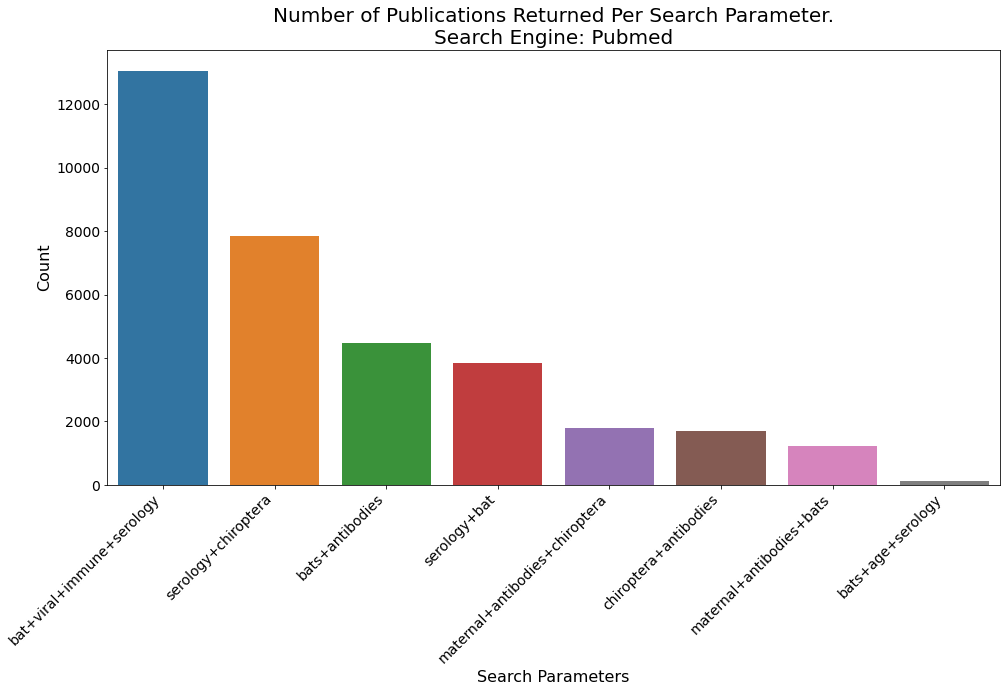

In [10]:
plt.figure(figsize=(16,8))
sns.barplot(x='Query Parameters', y='count', data=queryCounts)
plt.xlabel("Search Parameters", fontsize=16);
plt.ylabel("Count", fontsize=16);
plt.xticks(rotation=45, ha="right", fontsize=14)
plt.yticks(fontsize=14)
plt.title('Number of Publications Returned Per Search Parameter.\nSearch Engine: Pubmed', fontsize=20)
plt.show()

In [13]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time

search_terms = open("search_engine_parameters_modified.txt", "r")

titles = []
authors = []
description = []
links = []
parameters = []


def scrape_google_scholar(parameter):
    
    #Using webdriver to go to Google Scholar
    driver = webdriver.Chrome()
    driver.get("https://scholar.google.com/schhp?hl=en&as_sdt=0,48")

    #Finding search bar, inputting parameter and hitting enter
    search = driver.find_element(By.NAME, 'q')
    search.send_keys(parameter)
    search.send_keys(Keys.RETURN)
  
    counter = 1
    while counter <= 2:
        #getting current url for BS webscrapping, setting up lists for DF
        url = driver.current_url
        #Scraping title, link, authors, and description, adding to lists then adding lists to DF
        response=requests.get(url)
        soup = BeautifulSoup(response.content, 'lxml')  
        for item in soup.select('[data-lid]'):
            t = item.select('h3')[0].get_text() #title
            print(f'found item {t} on page {counter} for parameter {parameter}')
            titles.append(t)
            a = item.select('.gs_a')[0].get_text() #author
            authors.append(a)
            d = item.select('.gs_rs')[0].get_text() #description
            description.append(d)
            l = item.select('a')[0]['href']
            links.append(l)
            parameters.append(parameter)
        sleep_time = (30-5)*np.random.random()+5
        time.sleep(sleep_time) #from 5 to 30 seconds
        counter += 1
        next_page = driver.find_element(By.XPATH, '//*[@id="gs_n"]/center/table/tbody/tr/td[12]/a/b')
        next_page.click()
    
for value in search_terms:
    scrape_google_scholar(value.replace('\n', ''))
    
search_engine = ["Google Scholar" for value in titles]
    
gs_df = pd.DataFrame(list(zip(titles, authors, description, links, parameters, search_engine)), columns = ["Titles", "Authors", "Description", "Links", "Parameters", "Search Engine"])

found item [HTML][HTML] Bat-borne virus diversity, spillover and emergence on page 1 for parameter bat+viral+immune+serology
found item [HTML][HTML] Support for viral persistence in bats from age-specific serology and models of maternal immunity on page 1 for parameter bat+viral+immune+serology
found item [HTML][HTML] Novel insights into immune systems of bats on page 1 for parameter bat+viral+immune+serology
found item Immune system modulation and viral persistence in bats: understanding viral spillover on page 1 for parameter bat+viral+immune+serology
found item [HTML][HTML] Robust dengue virus infection in bat cells and limited innate immune responses coupled with positive serology from bats in IndoMalaya and Australasia on page 1 for parameter bat+viral+immune+serology
found item [HTML][HTML] Duration of maternal antibodies against canine distemper virus and Hendra virus in pteropid bats on page 1 for parameter bat+viral+immune+serology
found item Disentangling serology to elucidat

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id="gs_n"]/center/table/tbody/tr/td[12]/a/b"}
  (Session info: chrome=110.0.5481.178)
Stacktrace:
Backtrace:
	(No symbol) [0x00D937D3]
	(No symbol) [0x00D28B81]
	(No symbol) [0x00C2B36D]
	(No symbol) [0x00C5D382]
	(No symbol) [0x00C5D4BB]
	(No symbol) [0x00C93302]
	(No symbol) [0x00C7B464]
	(No symbol) [0x00C91215]
	(No symbol) [0x00C7B216]
	(No symbol) [0x00C50D97]
	(No symbol) [0x00C5253D]
	GetHandleVerifier [0x0100ABF2+2510930]
	GetHandleVerifier [0x01038EC1+2700065]
	GetHandleVerifier [0x0103C86C+2714828]
	GetHandleVerifier [0x00E43480+645344]
	(No symbol) [0x00D30FD2]
	(No symbol) [0x00D36C68]
	(No symbol) [0x00D36D4B]
	(No symbol) [0x00D40D6B]
	BaseThreadInitThunk [0x76307D69+25]
	RtlInitializeExceptionChain [0x775DBB9B+107]
	RtlClearBits [0x775DBB1F+191]


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS
import contractions
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

text = " ".join(gs_df.Description)

#Fix contractions
new_word = contractions.fix(text)
#Lemmatize
lem_word = lemmatizer.lemmatize(new_word)

#Wordcloud with removed stopwords
stopwords = ['bats', 'bat'] + list(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="black").generate(lem_word)
plt.figure(figsize = (15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [14]:
#Creating NA lists for values not in the Google Scholar DF; 
#I actually dont think I need to do this I thing PD does it automatically but cant verify
#pub_year = [np.nan for value in gs_df.titles]
#j_source = [np.nan for value in gs_df.titles]
#citation = [np.nan for value in gs_df.titles]
#pub_date = [np.nan for value in gs_df.titles]
#DOI = [np.nan for value in gs_df.titles]
#time_stamp = [np.nan for value in gs_df.titles]

#merge pubmed df and google scholar df
pd.concat([df,gs_df], ignore_index = True)

NameError: name 'gs_df' is not defined